In [80]:
import pandas as pd
import numpy as np

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix

# Data understanding

## Data loading

In [129]:
df = pd.read_csv('../data/dataset_tagged.csv')
df.shape

(77983, 4)

In [130]:
df.head()

,First Name,Last Name,Management Level,Title
0,Ann,Beard,NaN,"Senior Manager, Enterprise Readiness"
1,Christy,Stropes,NaN,Senior Knowledge Management Coordinator
2,Eric,Kerr,NaN,NaN
3,Andrew,Beam,NaN,Work At Home Department Manager
4,Suzana,Djordjevic,Manager-Level,Director of Operations


In [131]:
df = df.rename(
    columns={
        'Management Level': 'management_level',
        'Title': 'title'
    }
)

## Data exploration

### Missing values

In [132]:
df.isna().sum()

First Name            37
Last Name              0
management_level    1807
title                403
dtype: int64

### Features

In [133]:
df['title'].unique().shape

(46483,)

In [134]:
df['management_level'].value_counts()

Director-Level    31418
VP-Level          29794
Manager-Level      7094
C-Level            4226
Other              3608
Director             31
Manager               4
Non-Manager           1
Name: management_level, dtype: int64

In [135]:
# Unify categories

df['management_level'] = np.where(
    df['management_level'] == 'Non-Manager',
    'Other',
    df['management_level']
)

df['management_level'] = np.where(
    df['management_level'] == 'Manager',
    'Manager-Level',
    df['management_level']
)

df['management_level'] = np.where(
    df['management_level'] == 'Director',
    'Director-Level',
    df['management_level']
)


# Remove NANs
df = df[df['management_level'].notna()]

# Fill missing titles
df['title_filled'] = np.where(
    df['title'].isna(),
    'None',
    df['title']
).astype(str)

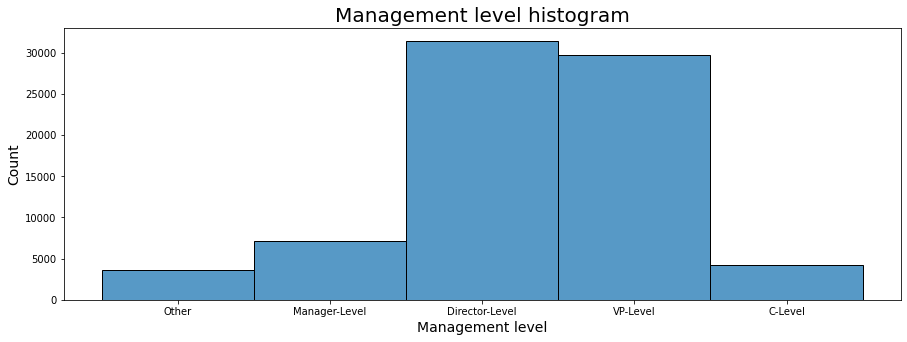

In [136]:
df['management_level'] = pd.Categorical(
    df['management_level'],
    ['Other', 'Manager-Level','Director-Level','VP-Level','C-Level']
)

fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(
    df['management_level'],
    discrete=True,
    ax=ax
)
ax.set_title('Management level histogram', fontsize=20)
ax.set_xlabel('Management level', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
plt.show()

## Keywords-in-title features

### Add regex features

In [137]:
relevant_title_parts_per_management_level = {
    'c_level': [
        'chief', 'ceo', 'cto', 'cpo', 'cso', 'coo', 'cfo', 'cmo', 'cio', 'cao', 'chro',
        'president', 'global head'
    ],
    'vp_level': ['vp', 'vice president', 'vice-president'],
    'director_level': ['director', 'dir.', 'directeur'],
    'manager_level': ['manager', 'team lead', 'team-lead'],
}

substrings_to_exclude_per_management_level = {
    'c_level': ['coordin', 'director', 'vice'],
    'vp_level': [],
    'director_level': [],
    'manager_level': [],
}

In [138]:
def check_if_title_contains_keyword(title, list_of_keywords):
    for keyword in list_of_keywords:
        if keyword in title.lower():
            return 1
    return 0

In [139]:
for level, list_of_keywords in relevant_title_parts_per_management_level.items():
    df[f'title_has_{level}_parts'] = df['title_filled'].apply(
        lambda title: check_if_title_contains_keyword(title, list_of_keywords)
    )


for level, substrings_to_exclude in substrings_to_exclude_per_management_level.items():
    for sub_s in substrings_to_exclude:
        df[f'title_has_{level}_parts'] = np.where(
            (df[f'title_has_{level}_parts'] == 1) &
            (df['title_filled'].apply(lambda s: s.lower()).str.contains(sub_s)),
            0,
            df[f'title_has_{level}_parts']
        )

In [140]:
title_parts_columns = [f'title_has_{level}_parts' for level in relevant_title_parts_per_management_level.keys()]
df[['title_filled'] + title_parts_columns].head()

,title_filled,title_has_c_level_parts,title_has_vp_level_parts,title_has_director_level_parts,title_has_manager_level_parts
4,Director of Operations,0,0,1,0
5,Executive VP & Chief Financial Officer,1,1,0,0
6,"Vice President, Human Resources",0,1,0,0
7,"Senior Director, Operations",0,0,1,0
8,"Senior Director, Recovery Operations",0,0,1,0


### Analyze new features

In [141]:
df['title_parts_amount'] = df[title_parts_columns].sum(axis=1)

In [142]:
df['title_parts_amount'].value_counts()

1    64000
0     7576
2     4590
3       10
Name: title_parts_amount, dtype: int64

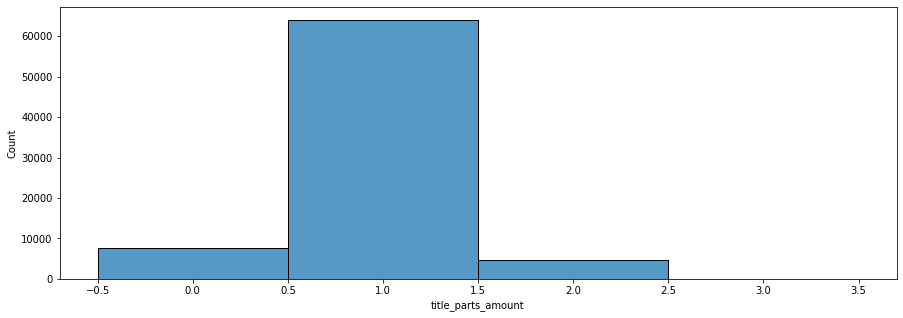

In [143]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(df['title_parts_amount'], discrete=True, ax=ax)
plt.show()

#### "Other" management level analysis

In [144]:
other_management_level_df = df[df['management_level'] == 'Other']
other_management_level_df[title_parts_columns].mean()

title_has_c_level_parts           0.018842
title_has_vp_level_parts          0.002771
title_has_director_level_parts    0.009698
title_has_manager_level_parts     0.032419
dtype: float64

In [145]:
list(other_management_level_df[other_management_level_df.title_has_c_level_parts == 1].head().title_filled)

['CSO CRM Operations',
 'Contractor',
 'CTO',
 'CHRO',
 'Senior HR CAO & IMO Business Partner']

In [146]:
list(other_management_level_df[other_management_level_df.title_has_vp_level_parts == 1].head().title_filled)

['VP of Training and Talent Development',
 'Executive VP, Operations',
 'Vice President, Testing & Division Manager',
 'AVP Learning Engagement',
 'Vice President, Technology']

In [147]:
list(other_management_level_df[other_management_level_df.title_has_director_level_parts == 1].head().title_filled)

['Director Information Technology Systems at Amdocs',
 'Site Director',
 'Director, Site Operations',
 'Asst. Dir. IT, Business Resilience',
 'Director of Learning']

In [148]:
list(other_management_level_df[other_management_level_df.title_has_manager_level_parts == 1].head().title_filled)

['Team Leader, Toyota Customer Service',
 'Team Leader ï Health and Service Support',
 'Team Leader',
 'Learning Manager',
 'Account Manager']

# Performance

## Assign predictions as the highest level found

In [149]:
management_level_mapping = {
    'Other': 0,
    'Manager-Level': 1,
    'Director-Level': 2,
    'VP-Level': 3,
    'C-Level': 4,
}

management_level_reverse_mapping = {
    0: 'Other',
    1: 'Manager-Level',
    2: 'Director-Level',
    3: 'VP-Level',
    4: 'C-Level'
}

In [184]:
df['management_level_int'] = df['management_level'].apply(
    lambda management_level: management_level_mapping[management_level]
).astype(int)

In [185]:
# 'Other'
df['pred_int'] = 0 

# 'Manager-Level'
df['pred_int'] = np.where(
    df['title_has_manager_level_parts'] == 1,
    1,
    df['pred_int']
)

# 'Director-Level'
df['pred_int'] = np.where(
    df['title_has_director_level_parts'] == 1,
    2,
    df['pred_int']
)

# 'VP-Level'
df['pred_int'] = np.where(
    df['title_has_vp_level_parts'] == 1,
    3,
    df['pred_int']
)

# C-Level
df['pred_int'] = np.where(
    df['title_has_c_level_parts'] == 1,
    4,
    df['pred_int']
)

In [186]:
df['pred'] = df['pred_int'].apply(
    lambda pred_int: management_level_reverse_mapping[pred_int]
)

## Check performance

### Accuracy

In [187]:
(df['management_level_int'] == df['pred_int']).mean()

0.9117963663095988

### Confusion matrix

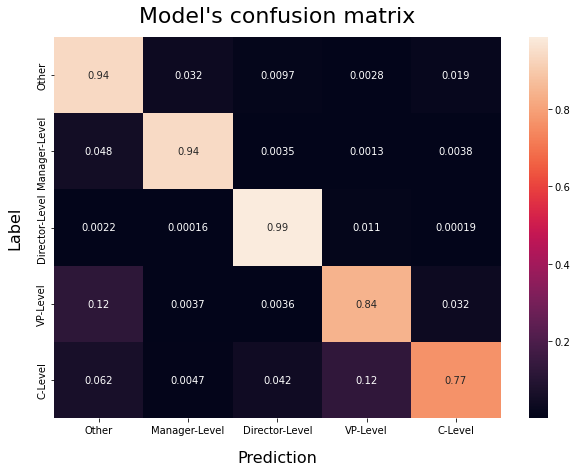

In [189]:
cm = confusion_matrix(df['management_level_int'], df['pred_int'])
cm_norm = []
for i in range(cm.shape[0]):
    curr_row = cm[i]
    cm_norm.append(curr_row / curr_row.sum())

cm_norm = np.array(cm_norm)

fig,ax = plt.subplots(figsize=(10, 7))
_ = sns.heatmap(
    cm_norm,
    annot=True,
    xticklabels=management_level_mapping.keys(),
    yticklabels=management_level_mapping.keys(),
    ax=ax
)

plt.title("Model's confusion matrix", fontsize=22, pad=15)
plt.xlabel('Prediction', fontsize=16, labelpad=15)
plt.ylabel('Label', fontsize=16, labelpad=15)
plt.show()

### Number of management levels misses

In [201]:
df['management_levels_diff'] = df['management_level_int'] - df['pred_int']
df['abs_management_levels_diff'] = np.abs(df['management_level_int'] - df['pred_int'])

In [205]:
df['management_levels_diff'].mean(), df['abs_management_levels_diff'].mean()

(0.15045421130014702, 0.20060123923545473)

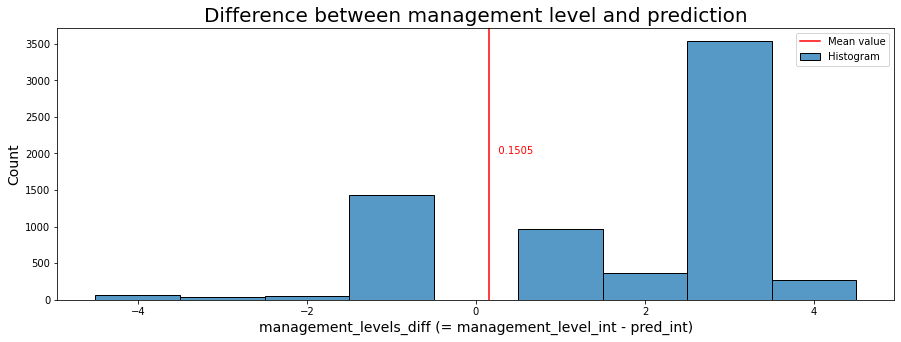

In [227]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(
    df[df['management_levels_diff'] != 0].management_levels_diff,
    discrete=True,
    label='Histogram',
    ax=ax
)
ax.axvline(df['management_levels_diff'].mean(), color='red', label='Mean value')
ax.annotate(
    f"{df['management_levels_diff'].mean():9.4f}",
    xy=(df['management_levels_diff'].mean(), 2000),
    color='red'
)

ax.set_title('Difference between management level and prediction', fontsize=20)
ax.set_xlabel("management_levels_diff (= management_level_int - pred_int)", fontsize=14)
ax.set_ylabel('Count', fontsize=14)

ax.legend()
plt.show()

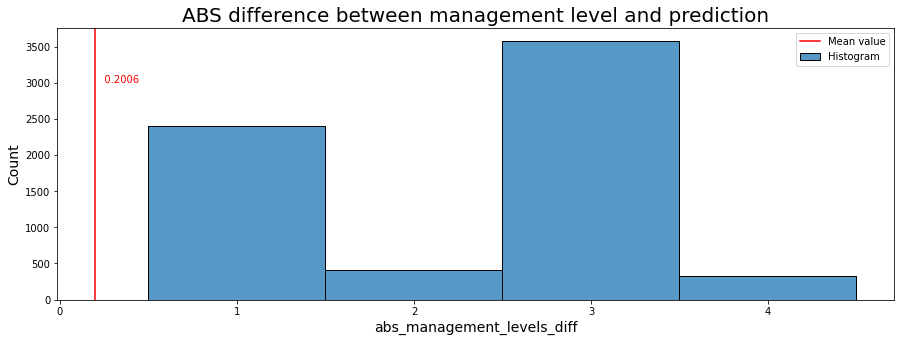

In [228]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(
    df[df['abs_management_levels_diff'] != 0].abs_management_levels_diff,
    discrete=True,
    label='Histogram',
    ax=ax
)
ax.axvline(df['abs_management_levels_diff'].mean(), color='red', label='Mean value')
ax.annotate(
    f"{df['abs_management_levels_diff'].mean():9.4f}",
    xy=(df['abs_management_levels_diff'].mean(), 3000),
    color='red'
)


ax.set_title('ABS difference between management level and prediction', fontsize=20)
ax.set_xlabel("abs_management_levels_diff", fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.legend()
plt.show()

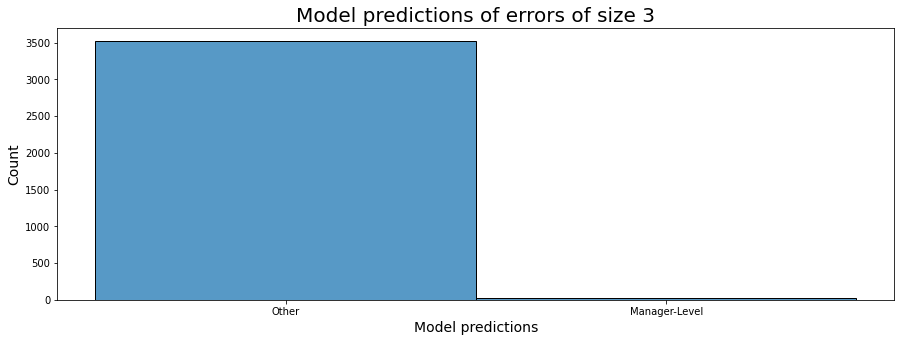

In [232]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(
    df[df['management_levels_diff'] == 3].pred,
    discrete=True,
    label='Histogram',
    ax=ax
)

ax.set_title('Model predictions of errors of size 3', fontsize=20)
ax.set_xlabel("Model predictions", fontsize=14)
ax.set_ylabel('Count', fontsize=14)

plt.show()

## Error analysis

In [175]:
df['pred'] = df['pred_int'].apply(
    lambda management_level_int: management_level_reverse_mapping[management_level_int]
)

In [176]:
df[
    (df['management_level_int'] == 0) &
    (df['management_level_int'] != df['pred_int'])
].drop_duplicates(subset='pred_int')[['title_filled', 'management_level', 'pred']].reset_index(drop=True)

,title_filled,management_level,pred
0,CSO CRM Operations,Other,C-Level
1,VP of Training and Talent Development,Other,VP-Level
2,"Team Leader, Toyota Customer Service",Other,Manager-Level
3,Director Information Technology Systems at Amdocs,Other,Director-Level


In [177]:
df[
    (df['management_level_int'] == 1) &
    (df['management_level_int'] != df['pred_int'])
].drop_duplicates(subset='pred_int')[['title_filled', 'management_level', 'pred']].reset_index(drop=True)

,title_filled,management_level,pred
0,Director of Operations,Manager-Level,Director-Level
1,"Manager, CSO & Solutions Operations Section",Manager-Level,C-Level
2,Training and Onboarding Manage,Manager-Level,Other
3,VP Operations EMEA,Manager-Level,VP-Level


In [178]:
df[
    (df['management_level_int'] == 2) &
    (df['management_level_int'] != df['pred_int'])
].drop_duplicates(subset='pred_int')[['title_filled', 'management_level', 'pred']].reset_index(drop=True)

,title_filled,management_level,pred
0,"VP - Training, Quality & Talent Development",Director-Level,VP-Level
1,Global Deputy Chief Client Officer,Director-Level,C-Level
2,"Readiness People & Culture Lead, Modern Life, ...",Director-Level,Other
3,"National Program Manager, Tech",Director-Level,Manager-Level


In [179]:
df[
    (df['management_level_int'] == 3) &
    (df['management_level_int'] != df['pred_int'])
].drop_duplicates(subset='pred_int')[['title_filled', 'management_level', 'pred']].reset_index(drop=True)

,title_filled,management_level,pred
0,Executive VP & Chief Financial Officer,VP-Level,C-Level
1,"Global Head, Customer Experience & Enterprise ...",VP-Level,Other
2,"Senior Head of Operations, Operations Manager",VP-Level,Manager-Level
3,Managing Director / Presidente Philip Morris F...,VP-Level,Director-Level


In [180]:
df[
    (df['management_level_int'] == 4) &
    (df['management_level_int'] != df['pred_int'])
].drop_duplicates(subset='pred_int')[['title_filled', 'management_level', 'pred']].reset_index(drop=True)

,title_filled,management_level,pred
0,Director,C-Level,Director-Level
1,Coordinador de Comunicaciones,C-Level,Other
2,"Vice President, Strategic Initiatives (Office ...",C-Level,VP-Level
3,"Deputy Head of Customer Service, Site Manager,...",C-Level,Manager-Level
